In [8]:
import speech as sp
import numpy as np
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

In [9]:
def nrj_based_classification(x,threshold):
    fullband_nrj, subband_nrj = sp.process.frame_nrj(x)
    return subband_nrj/fullband_nrj > threshold

In [14]:
p = 10 #Order of the all pole filter
frame_size = 400 # Window size
iterations = 5 # Number of iterations of the Wiener Filter
threshold = 0.05

# Preparing the sample
x_clean, sr = sp.data.load('../samples/speech_male/arctic_a0004.wav')
SNR = 3
seed = 0
x = sp.data.add_white_noise(x_clean,SNR,seed)

# Get the list of frames for the STFT filtering
list_frames,x_padded,w_a,w_s = sp.data.frame_split(x,frame_size,with_overlap=True)
n_frames = len(list_frames)

# Create list of values per frame
s = np.zeros(x_padded.shape)
sigmas = np.zeros(len(list_frames))
is_speech_tmp = np.zeros(len(list_frames),dtype=bool)
is_speech = np.zeros(len(list_frames),dtype=bool)
filters = [None]*n_frames
speech_PSD = [None]*n_frames
noise_PSD = [None]*n_frames

# Initialize relevant values at frame 0, 1
sigmas[0] = np.std(x_padded[list_frames[0]])
is_speech_tmp[0] = False;
is_speech[0] = False;
is_speech_tmp[1] = nrj_based_classification(x_padded[list_frames[1]],threshold)
filters[0] = np.zeros(int(frame_size//2+1))


for k in range(1,n_frames-1): # What to do on last frame ?
    #1. Classify next frame
    is_speech_tmp[k+1] = nrj_based_classification(x_padded[list_frames[k+1]],threshold)
    
    #2. Improve classification of current frame by median smoothing
    is_speech[k] = bool(np.median(is_speech_tmp[k-1:k+2]))
    #is_speech[k] = is_speech_tmp[k]
    
    if(is_speech[k] and (np.sum(w_a*x_padded[list_frames[k]]**2) > frame_size*sigmas[k-1])): # If the frame is assumed to be speech
        # Update rule for sigma
        sigmas[k] = sigmas[k-1]
        
        # Through all pole model, compute a Wiener Filter and denoise the current frame
        denoised_frame, filters[k], speech_PSD[k], noise_PSD[k] = sp.process.denoise_frame(w_a*x_padded[list_frames[k]],p,sigmas[k]**2,iterations)
        s[list_frames[k]] = s[list_frames[k]] + w_s*denoised_frame
    else: # If the frame is assumed to be noise
        # Evaluate the noise PSD
        #sigmas[k] = np.std(x_padded[list_frames[k]]) #!!!!!CAREFUL
        sigmas[k] = sigmas[k-1] #For now : still assuming constant noise variance
        
        
        filters[k] = filters[k-1]
        speech_PSD[k] = speech_PSD[k-1]
        noise_PSD[k] = noise_PSD[k-1]
        s[list_frames[k]] = s[list_frames[k]] + w_s*(np.fft.irfft(filters[k]*np.fft.rfft(w_a*x[list_frames[k]])))
        
        



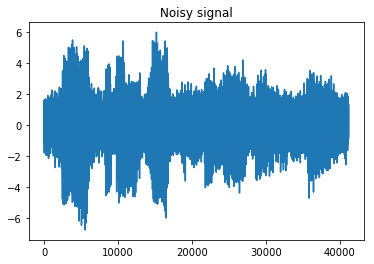

In [15]:
plt.plot(x)
plt.title('Noisy signal')
IPython.display.Audio(x,rate=sr)

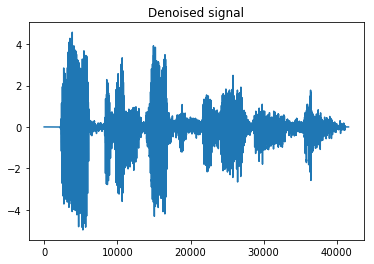

In [16]:
plt.plot(s)
plt.title('Denoised signal')
IPython.display.Audio(s,rate=sr)

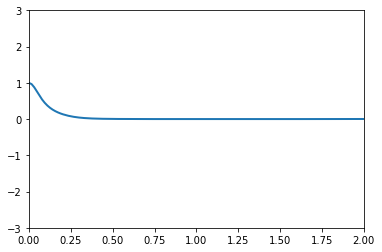

In [19]:
from matplotlib import animation
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-3, 3))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    omega = np.linspace(0,np.pi,int(frame_size//2) + 1)
    wf = filters[i]
    line.set_data(omega, wf)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames-1, interval=200, blit=True)
anim.save('filters.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.show()

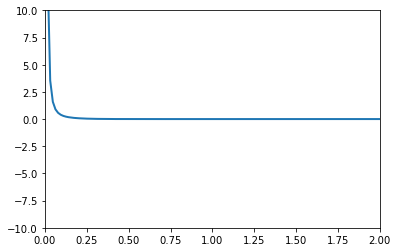

In [18]:
from matplotlib import animation
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-10, 10))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    omega = np.linspace(0,np.pi,int(frame_size//2) + 1)
    wf = speech_PSD[i]
    line.set_data(omega, wf)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames-1, interval=200, blit=True)
anim.save('speech_PSD.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.show()